In [369]:
import pandas as pd
import matplotlib.pyplot as plt


In [391]:
summary = pd.read_csv("../PCCArena/experiments/summary.csv")
summary.datasets.unique()


array(['CAPOD', 'Debug_SNC', 'Debug_SNCC', 'Sample_SNC', 'blensor',
       's3dis'], dtype=object)

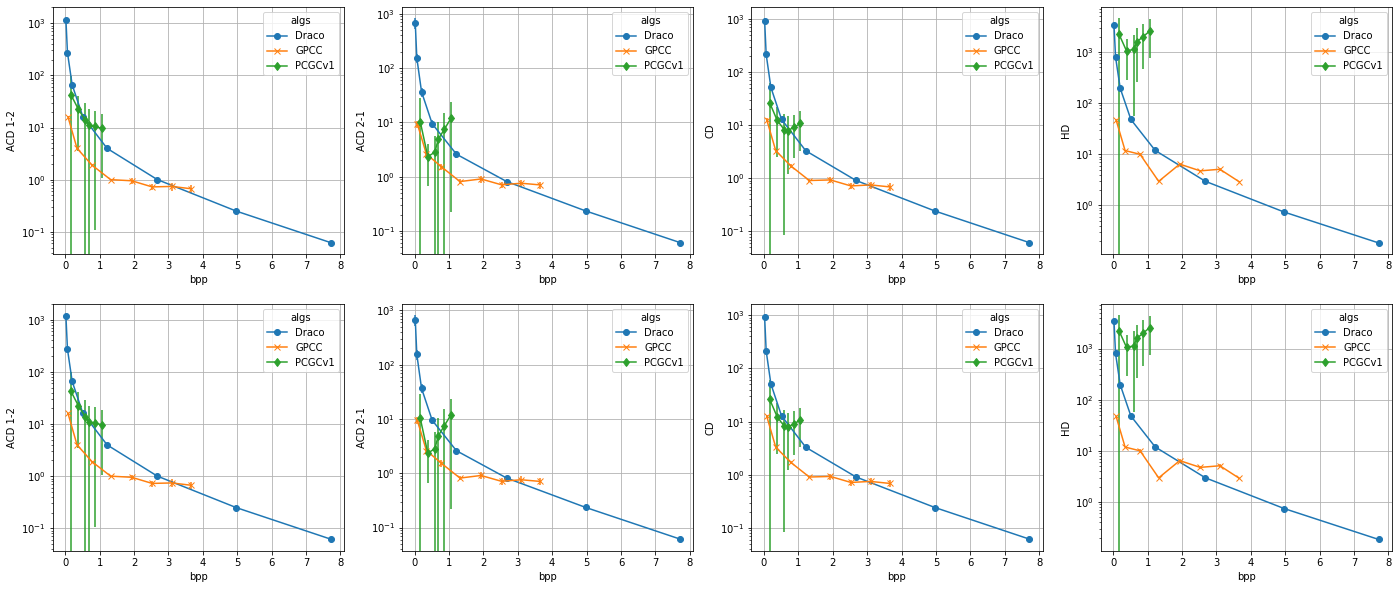

In [405]:
# try to recreate the metric/bpp graphs from the paper
# ACD to BPP per algorithm
summary = pd.read_csv("../PCCArena/experiments/summary.csv")

# datasets = ["s3dis", "blensor"]
datasets = ["CAPOD", "CAPOD"]

col2label = {
    "acd12_p2pt": "ACD 1-2",
    "acd21_p2pt": "ACD 2-1",
    "cd_p2pt": "CD",
    "h_p2pt": "HD"
}

relevant_cols = list(col2label.keys())

fig, axes = plt.subplots(nrows=len(datasets), ncols=len(relevant_cols))
fig.set_figwidth(24)
fig.set_figheight(10)

alg2marker = {
    "Draco": "o",
    "GPCC": "x",
    "PCGCv1": "d",
    "PCGCv2": "d",
    "GeoCNNv1": "x",
    "GeoCNNv2": "^"
}

for i, dataset in enumerate(datasets):
    filtered = summary[summary.datasets == dataset]
    filtered = filtered[relevant_cols + ["algs", "rate", "bpp"]]

    groups = filtered.groupby(['algs', 'rate'])
    means = groups.mean()
    std = groups.std()
    std["bpp"] = means["bpp"]

    means = means.reset_index()
    std = std.reset_index()

    for j, col in enumerate(relevant_cols):
        for alg in ['Draco', 'GPCC', 'PCGCv1']:
            _means = means[means["algs"] == alg]
            _std = std[std["algs"] == alg]
            pivoted_means = _means.pivot(index='bpp', columns='algs', values=col)
            pivoted_std = _std.pivot(index='bpp', columns='algs', values=col)
            pivoted_means.plot(ax=axes[i, j],kind="line", yerr=pivoted_std, marker=alg2marker[alg], logy=True, ylabel=col2label[col], grid=True)

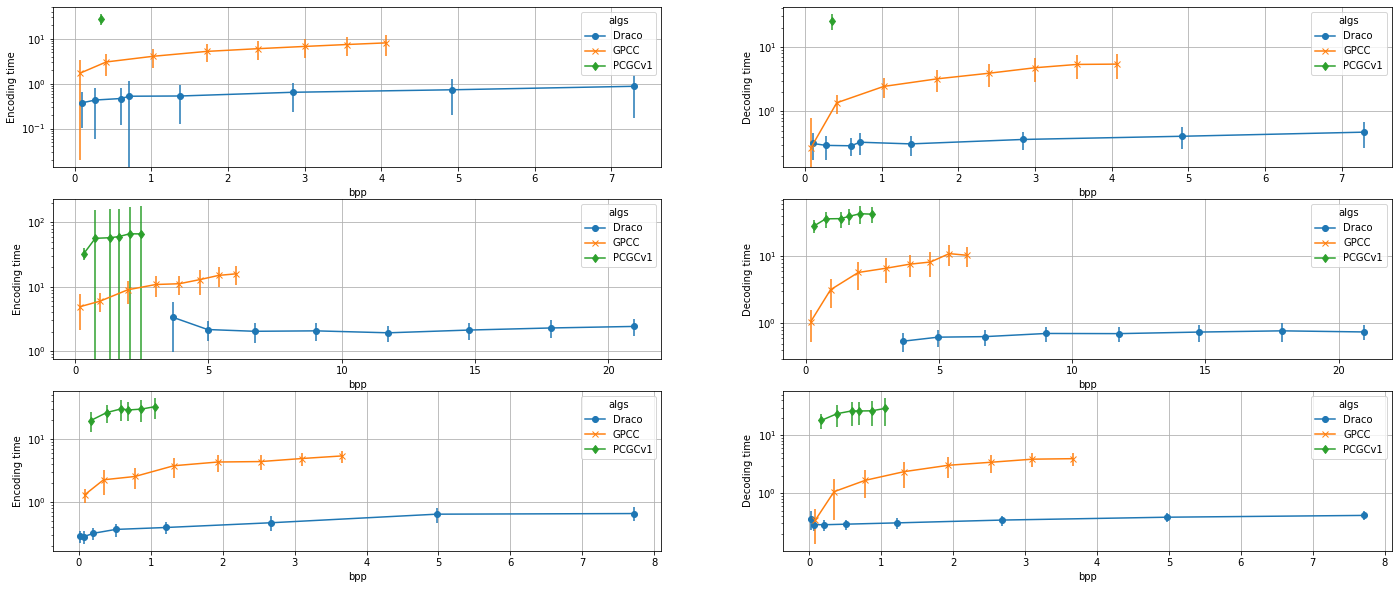

In [402]:
# try to recreate the metric/bpp graphs from the paper
# encoding time to bpp per algorithm
summary = pd.read_csv("../PCCArena/experiments/summary.csv")

datasets = ["s3dis", "blensor", "CAPOD"]

col2label = {
    "encT": "Encoding time",
    "decT": "Decoding time"    
}

relevant_cols = list(col2label.keys())

fig, axes = plt.subplots(nrows=len(datasets), ncols=len(relevant_cols))
fig.set_figwidth(24)
fig.set_figheight(10)

alg2marker = {
    "Draco": "o",
    "GPCC": "x",
    "PCGCv1": "d"
}

for i, dataset in enumerate(datasets):
    filtered = summary[summary.datasets == dataset]
    filtered = filtered[relevant_cols + ["algs", "rate", "bpp"]]

    groups = filtered.groupby(['algs', 'rate'])
    means = groups.mean()
    std = groups.std()
    std["bpp"] = means["bpp"]


    means = means.reset_index()
    std = std.reset_index()

    for j, col in enumerate(relevant_cols):
        for alg in ['Draco', 'GPCC', 'PCGCv1']:
            _means = means[means["algs"] == alg]
            _std = std[std["algs"] == alg]
            pivoted_means = _means.pivot(index='bpp', columns='algs', values=col)
            pivoted_std = _std.pivot(index='bpp', columns='algs', values=col)
            pivoted_means.plot(ax=axes[i, j],kind="line", yerr=pivoted_std, marker=alg2marker[alg], ylabel=col2label[col], logy=True, grid=True)

<AxesSubplot:xlabel='letter,word'>

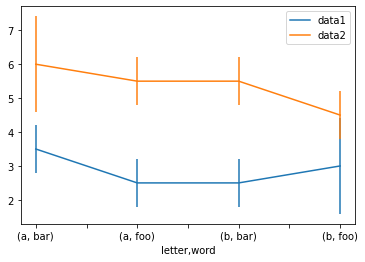

In [341]:
ix3 = pd.MultiIndex.from_arrays([['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'], ['foo', 'foo', 'bar', 'bar', 'foo', 'foo', 'bar', 'bar']], names=['letter', 'word'])

df3 = pd.DataFrame({'data1': [3, 2, 4, 3, 2, 4, 3, 2], 'data2': [6, 5, 7, 5, 4, 5, 6, 5]}, index=ix3)

gp3 = df3.groupby(level=('letter', 'word'))

means = gp3.mean()

errors = gp3.std()


fig, ax = plt.subplots()

means.plot(yerr=errors, ax=ax)